# Latin prose/verse classification with RF classifier and full feature set


In [1]:
# Pacotes de pré-processamento
from sklearn import preprocessing
from sklearn.utils import shuffle

# Load pandas and numpy
import pandas as pd
import numpy as np

# Classificadores
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score


# Validação cruzada
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics


# Visualização dos resultados
import shap


# Plot
import matplotlib.pyplot as plt

In [2]:
# Seed random number generator so that identical results will be generated each time
np.random.seed(0)

In [3]:
# Load data
df0 = pd.read_csv("stylometry_data_final.csv")

# Shuffle the order of the texts
df = shuffle(df0, random_state=1)

In [4]:
df.head()

,Personal Pronouns,Demonstrative Pronouns,Quidam,Reflexive Pronouns,Iste,Alius,Ipse,Idem,Priusquam,Antequam,...,Gerunds and Gerundives,Cum,Conjunctions,Vocatives,Mean Sentence Length,Characters,Words,Corpus Name,Sentences,Type
579,0.00020,0.00658,0.00005,0.00098,0.00000,0.00059,0.00032,0.00027,0.00000,0.0001,...,0.00044,0.00166,0.01694,0.00000,139.52381,"41,020","6,918",Vitruvius De Architectura Part 2,294,Prose
284,0.00106,0.00175,0.00006,0.00086,0.00000,0.00040,0.00112,0.00023,0.00000,0.0000,...,0.00066,0.00046,0.02248,0.00000,125.43885,"34,872","6,091",Manilius Astronomicon Part 4,278,Verse
23,0.00336,0.00220,0.00028,0.00031,0.00060,0.00038,0.00110,0.00019,0.00000,0.0000,...,0.00031,0.00016,0.01305,0.00000,214.87162,"31,801","4,920",Apuleius Metamorphoses Part 11,148,Prose
494,0.00217,0.00372,0.00000,0.00040,0.00000,0.00025,0.00054,0.00014,0.00000,0.0000,...,0.00022,0.00007,0.01695,0.00011,167.64848,"27,662","4,757",Statius Thebaid Part 2,165,Verse
547,0.00329,0.00402,0.00000,0.00065,0.00019,0.00038,0.00073,0.00015,0.00004,0.0000,...,0.00011,0.00023,0.01642,0.00004,87.40134,"26,133","4,663",Valerius Flaccus Argonautica Part 5,299,Verse


In [5]:
array = df.values

# Matriz de covariáveis
X = array[:,0:26]

# Legenda
Y = array[:,30]
features = df.columns[0:26]


Padronizando os dados entre 0 e 1

In [6]:
# Rescale data so that min is 0 and max is 1
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)

## Random Forest

### Testando tunagem do modelo

In [7]:
param_grid = {
    "max_depth": [2, 3, 4, 5, 6],
    "max_features": ["auto", "sqrt", "log2"],
    "n_estimators": [10, 20, 50, 100]
}

rf = RandomForestClassifier()
rf_cv = model_selection.GridSearchCV(estimator=rf, param_grid=param_grid, cv=10)
rf_cv.fit(X_scaled, Y)

# Mostrando os melhores parâmetros
rf_cv.best_params_

{'max_depth': 6, 'max_features': 'auto', 'n_estimators': 20}

### Validação cruzada 5-fold


Como não fizemos nenhum tratamento nos dados, vamos usar a própria validação do pacote

In [8]:
clf = RandomForestClassifier(n_estimators=50, min_samples_leaf=10, max_depth = 6)
results = model_selection.cross_val_score(clf, X_scaled, Y, cv=5, scoring='accuracy')

### Acurácia de cada fold

In [9]:
df_results = pd.DataFrame(results)

df_results

,0
0,0.974576
1,0.991525
2,0.965812
3,0.991453
4,0.965812


In [10]:
results.mean()

0.9778357235984355

### Legendando os dados com o real vs. predito

In [11]:
predictions = np.matrix(list(zip(cross_val_predict(clf, X_scaled, Y, cv=5))))
df_predictions = pd.DataFrame(predictions)
df_names = df[['Corpus Name', 'Type']]
output = np.concatenate([df_names, df_predictions], axis=1)
df_output = pd.DataFrame(output)

df_output.head()

,0,1,2
0,Vitruvius De Architectura Part 2,Prose,Prose
1,Manilius Astronomicon Part 4,Verse,Verse
2,Apuleius Metamorphoses Part 11,Prose,Prose
3,Statius Thebaid Part 2,Verse,Verse
4,Valerius Flaccus Argonautica Part 5,Verse,Verse


# Explicando o modelo Random Forest

### Feature ranking por importancia de Gini

In [12]:
clf.fit(X_scaled,Y)
rankings = np.matrix(sorted(list(zip(features, clf.feature_importances_)), key=lambda x: x[1]))

In [13]:
# Print feature rankings to file
df_rankings = pd.DataFrame(rankings[::-1])
df_rankings[:11]

,0,1
0,Relative Clauses,0.22135789533165803
1,Superlatives,0.198539066898764
2,Quidam,0.17068546476121393
3,Prepositions,0.08291519786817306
4,Idem,0.08173443933378975
5,Vocatives,0.0524600206881329
6,Gerunds and Gerundives,0.044411397834584386
7,Dum,0.029153605560220907
8,Demonstrative Pronouns,0.02238707884708819
9,Ut,0.01921376319949409


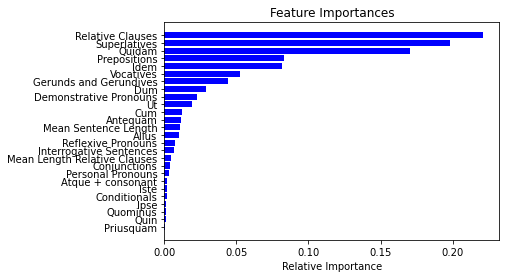

In [14]:
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Rankeando com o shap

O shap é um pacote que pode ser utilizado quando a finalidade é tentar entender o que está acontecendo em um determinado modelo

In [15]:
X = pd.DataFrame(X, columns = features)

#### Prosa

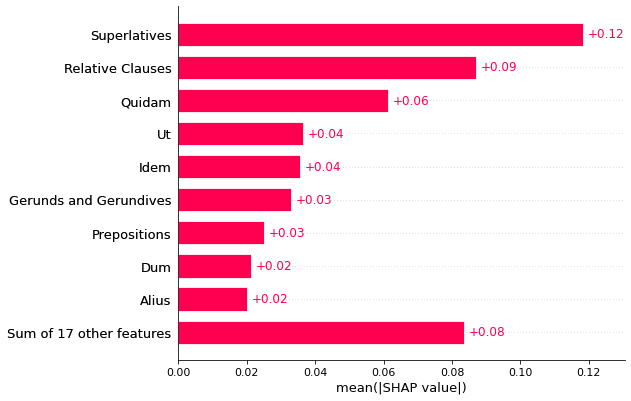

In [16]:
rf = clf.fit(X,Y)

explainer = shap.Explainer(rf)
shap_test = explainer(X)
shap.plots.bar(shap_test[:,:,0])

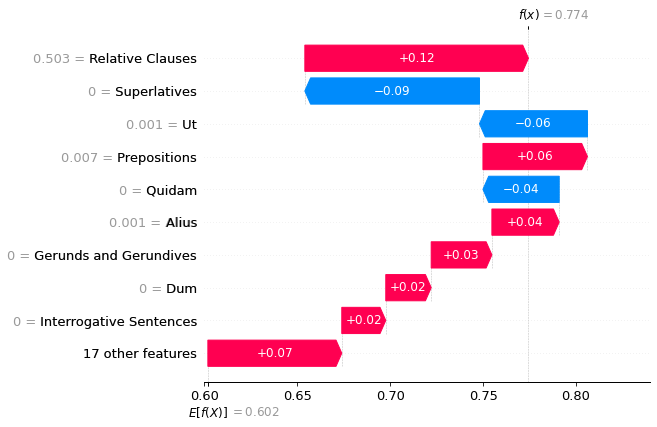

In [17]:
shap.plots.waterfall(shap_test[:,:,0][0]) # predição para uma observação

#### Verso

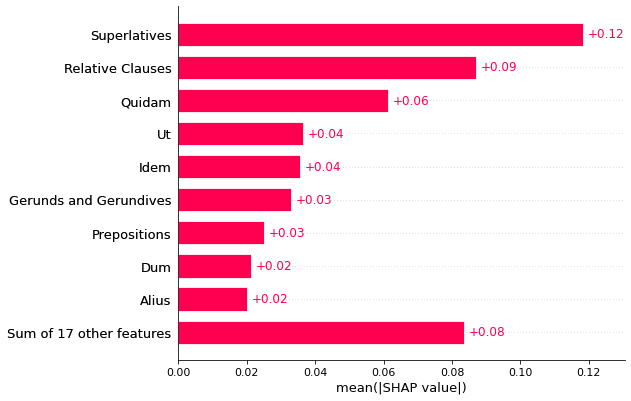

In [18]:
explainer = shap.Explainer(rf)
shap_test = explainer(X)
shap.plots.bar(shap_test[:,:,1])

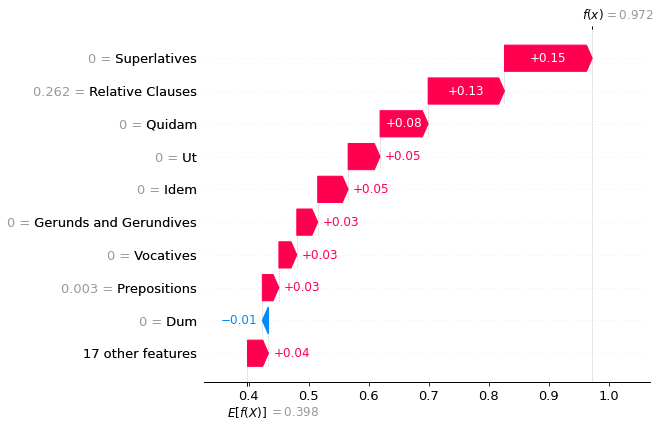

In [19]:
shap.plots.waterfall(shap_test[:,:,1][3]) # predicao de cada observacao

## AdaBoosting

In [20]:
# Criando grid com os parâmetros que vão ser testados
param_grid = {
    "n_estimators": [10,20,50,100,150],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.5, 0.8, 1]
}
# Criando o modelo
adb = AdaBoostClassifier()
adb_cv = model_selection.GridSearchCV(estimator=adb, param_grid=param_grid, cv=10)
adb_cv.fit(X_scaled, Y)

# Mostrando os melhores parâmetros
adb_cv.best_params_

{'learning_rate': 1, 'n_estimators': 100}

In [29]:
adb = AdaBoostClassifier(learning_rate = 0.1, n_estimators = 100)
results_ada = model_selection.cross_val_score(clf, X_scaled, Y, cv=5, scoring='accuracy')


ada_results = pd.DataFrame(results)
ada_results

,0
0,0.983051
1,1.000000
2,0.974359
3,0.965812
4,0.965812


In [30]:
ada_results.mean()

0    0.977807
dtype: float64

## Support Vector Machine

### 5-fold cross validation

In [21]:
clf = svm.SVC(kernel='linear',probability=True,C=0.5)
results = model_selection.cross_val_score(clf, X_scaled, Y, cv=5, scoring='accuracy')

# Print accuracies for each fold to file
df_results = pd.DataFrame(results)
df_results

,0
0,0.983051
1,1.000000
2,0.974359
3,0.965812
4,0.965812


In [22]:
results.mean()

0.9778067506881067

In [23]:
# Print predicted labels for each text to file
predictions = np.matrix(list(zip(cross_val_predict(clf, X_scaled, Y, cv=5))))
df_predictions = pd.DataFrame(predictions)
df_names = df[['Corpus Name', 'Type']]
output = np.concatenate([df_names, df_predictions], axis=1)
df_output = pd.DataFrame(output)

Peso das características

In [24]:
clf.fit(X_scaled,Y)
weights = list(clf.coef_)
weights_output = np.matrix(sorted(list(zip(features, weights[0])), key=lambda x: x[1]))

df_rankings = pd.DataFrame(weights_output)
df_rankings.head()

,0,1
0,Superlatives,-2.6910779690778868
1,Antequam,-1.6516790570077053
2,Relative Clauses,-1.5636895166121028
3,Quidam,-1.5315542470842236
4,Alius,-1.497268290016345
